# ATTN: This script should be run AFTER all embeddings are completed.


### START HERE IF SOURCING FROM df_manual_FOR_TRAINNING
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


# Descriptives and visualization


In [76]:
import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

sys.path.append(code_dir)
# %load_ext autoreload
# %autoreload 2


In [77]:
from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8


In [78]:
def df_gender_age_info(df, ivs_all=None):
    if ivs_all is None:
        ivs_all = [
            'Gender',
            'Gender_Num',
            'Gender_Female',
            'Gender_Mixed',
            'Gender_Male',
            'Age',
            'Age_Num',
            'Age_Older',
            'Age_Mixed',
            'Age_Younger',
        ]
    # Print Info
    print('\nDF INFO:\n')
    df.info()

    for iv in ivs_all:
        try:
            counts = df[f'{iv}'].value_counts()
            percentages = df[f'{iv}'].value_counts(normalize=True).mul(100).round(1).astype(float)
            print('='*20)
            print(f'{iv}:')
            print('-'*20)
            print(f'{iv} Counts:\n{counts}')
            print('-'*20)
            print(f'{iv} Percentages:\n{percentages}')

            with contextlib.suppress(Exception):
                mean = df[f"{iv}"].mean().round(2).astype(float)
                sd = df[f"{iv}"].std().round(2).astype(float)
                print('-'*20)
                print(f'{iv} Mean: {mean}')
                print('-'*20)
                print(f'{iv} Standard Deviation: {sd}')

        except Exception:
            print(f'{iv} not available.')

    print('\n')


In [79]:
# Function to order categories
def categorize_df_gender_age(df, gender_order=None, age_order=None, ivs=None):
    if gender_order is None:
        gender_order = ['Female', 'Mixed Gender', 'Male']
    if age_order is None:
        age_order = ['Older', 'Mixed Age', 'Younger']
    if ivs is None:
        ivs = ['Gender', 'Age']
    # Arrange Categories
    for iv in ivs:
        if iv == 'Gender':
            order = gender_order
        elif iv == 'Age':
            order = age_order
        try:
            df[iv] = df[iv].astype('category').cat.reorder_categories(order, ordered=True)

            df[iv] = pd.Categorical(
                df[iv], categories=order, ordered=True
            )
            df[f'{iv}_Num'] = pd.to_numeric(df[iv].cat.codes).astype('int64')
        except ValueError as e:
            print(e)

    return df


In [80]:
def make_barplot(df, iv, dvs_list):
    fig, ax = plt.subplots()
    fig.suptitle(f'Training Dataset: Warmth and Competence Sentence Percentages per {iv}')

    vars_list = [iv]
    vars_list.extend(dvs_list)

    df_pivot = df[
        vars_list
    ].pivot_table(
        index=iv, values=dvs_list, fill_value=0, aggfunc=lambda x: (100*x.sum())/len(df)
    )

    df_pivot.sort_values(by=iv, ascending=False).plot(kind='barh', legend=True, stacked=True, ax=ax, color=['C0', 'C5'])

    for _ in ax.containers:
        ax.set_xlabel('% Job Ad Sentences')
        ax.set_ylabel(iv)

    for save_format in ['eps', 'png']:
        fig.savefig(
            f'{plot_save_path}Barplot - Manually Annotated {iv} x {dvs_list[0]} and {dvs_list[1]} Sentences.{save_format}',
            format=save_format, dpi=3000, bbox_inches='tight'
        )

In [81]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_for_trainning.pkl').reset_index(drop=True)


In [82]:
# All info
analysis_columns = [
    'Warmth',
    'Competence'
]

df_manual = categorize_df_gender_age(df_manual)

df_manual.info()

# Gender and Age info by job ad
print('='*30)
print('Gender and Age info at Sentence Level')
print('-'*30)
df_gender_age_info(df_manual)

# Gender and Age info by job ad
print('='*30)
print('Gender and Age info at Job Advertisement Level')
print('-'*30)
df_gender_age_info(df_manual.groupby(['Job ID']).first())

# Warmth and Competence info by job ad
print('='*30)
print('Warmth and Competence info at Sentence Level')
print('-'*30)
df_gender_age_info(df_manual, ivs_all = analysis_columns)

# Warmth and Competence info by job ad
print('='*30)
print('Warmth and Competence info at Job Advertisement Level')
print('-'*30)
df_gender_age_info(df_manual.groupby(['Job ID']).first(), ivs_all = analysis_columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Columns: 221 entries, % Sector per Workforce to Job Description gensim_123grams_sent2vec_embeddings
dtypes: category(2), float64(24), int64(15), object(180)
memory usage: 10.0+ MB
Gender and Age info at Sentence Level
------------------------------

DF INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Columns: 221 entries, % Sector per Workforce to Job Description gensim_123grams_sent2vec_embeddings
dtypes: category(2), float64(24), int64(15), object(180)
memory usage: 10.0+ MB
Gender:
--------------------
Gender Counts:
Mixed Gender    4682
Male             664
Female           632
Name: Gender, dtype: int64
--------------------
Gender Percentages:
Mixed Gender   78.30
Male           11.10
Female         10.60
Name: Gender, dtype: float64
Gender_Num:
--------------------
Gender_Num Counts:
1    4682
2     664
0     632
Name: Gender_Num, dtype: int64
--------------------
Gender_Num 

In [83]:
# Imbalance Ratio
warmth_imbalance_ratio = df_manual['Warmth'].loc[
    df_manual['Warmth'] == 1].count()/df_manual['Warmth'].loc[df_manual['Warmth'] == 0
].count()
competence_imbalance_ratio = df_manual['Competence'].loc[
    df_manual['Competence'] == 1].count()/df_manual['Competence'].loc[df_manual['Competence'] == 0
].count()

all_imbalance_ratio_dict = {
    'Warmth': warmth_imbalance_ratio,
    'Competence': competence_imbalance_ratio
}

print('='*20)
print('Imabalance Ratios')
print('-'*10)
print(f'Warmth IR: {warmth_imbalance_ratio:.2f}')
print(f'Competence IR: {competence_imbalance_ratio:.2f}')
print('='*20)


Imabalance Ratios
----------
Warmth IR: 0.33
Competence IR: 0.78


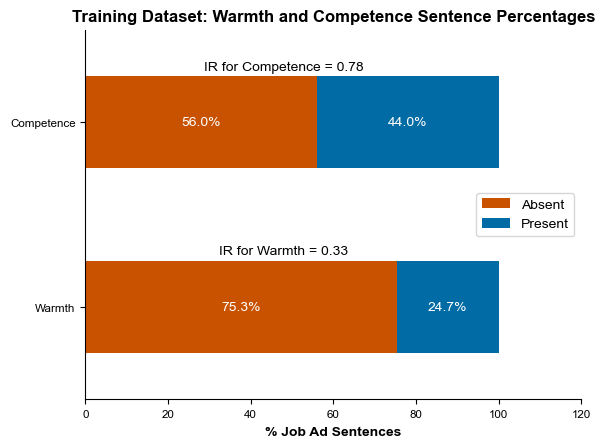

In [84]:
# Ploting Warmth and Competence
df_warm_comp_transposed = pd.concat(
    [
        df_manual['Warmth'].value_counts(normalize=True).mul(100).round(2).astype(float).to_frame().T,
        df_manual['Competence'].value_counts(normalize=True).mul(100).round(2).astype(float).to_frame().T,
    ]
)

fig, ax = plt.subplots()
ax.set_title('Training Dataset: Warmth and Competence Sentence Percentages')
ax.set_xlabel('Manually Annotated Sentencence Warmth and Competence Percentage from Total')

df_warm_comp_transposed.plot(
    kind='barh', legend=True, stacked=True, ax=ax, color=['C5', 'C0'],
)
ax.legend(['Absent', 'Present'])

for container in ax.containers:
    labels = [f'{width:.1f}%' for v in container if float(width:= v.get_width())]
    ax.bar_label(container, labels=labels, label_type='center', color='white')
    ax.set_xlabel('% Job Ad Sentences')

for i, tick_label in enumerate(ax.get_ymajorticklabels()):
    ax.annotate(
        f'IR for {tick_label.get_text()} = {all_imbalance_ratio_dict[tick_label.get_text()]:.2f}',
        xy=(48, 0.3+i), ha='center', va='center'
    )

for save_format in ['eps', 'png']:
    fig.savefig(
        f'{plot_save_path}Manually Annotated Warmth and Competence Sentences.{save_format}',
        format=save_format, dpi=3000, bbox_inches='tight'
    )


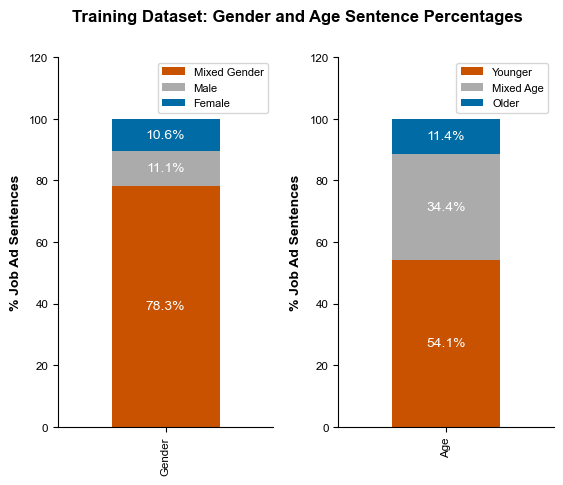

In [85]:
# Ploting Gender and Age
df_gender_transposed = df_manual['Gender'].value_counts(normalize=True).mul(100).round(2).astype(float).to_frame().T
df_age_transposed = df_manual['Age'].value_counts(normalize=True).mul(100).round(2).astype(float).to_frame().T

fig, axs = plt.subplots(1, 2)
fig.suptitle('Training Dataset: Gender and Age Sentence Percentages')

df_gender_transposed.plot(
    kind='bar', legend=True, stacked=True, ax=axs[0], color=['C5', 'C2', 'C0']
)
df_age_transposed.plot(
    kind='bar', legend=True, stacked=True, ax=axs[1], color=['C5', 'C2', 'C0']
)

for ax in axs:
    for container in ax.containers:
        labels = [f'{height:.1f}%' for v in container if float(height:= v.get_height())]
        ax.bar_label(container, labels=labels, label_type='center', color='white')
        ax.legend(loc='upper right', fontsize=8)
        ax.set_ylabel('% Job Ad Sentences')

for save_format in ['eps', 'png']:
    fig.savefig(
        f'{plot_save_path}Manually Annotated Gender and Age Sentences.{save_format}',
        format=save_format, dpi=3000, bbox_inches='tight'
    )


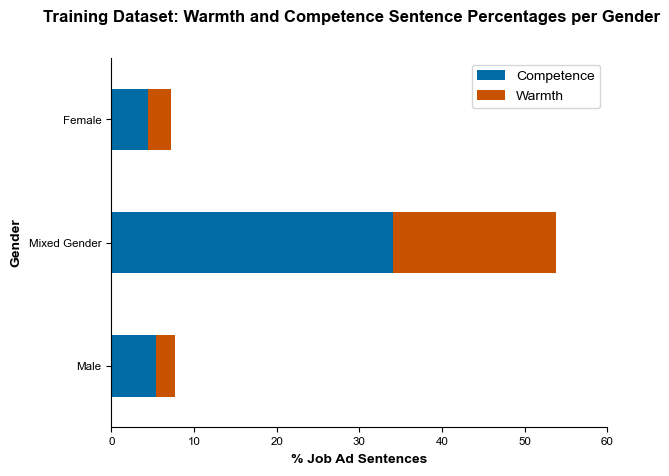

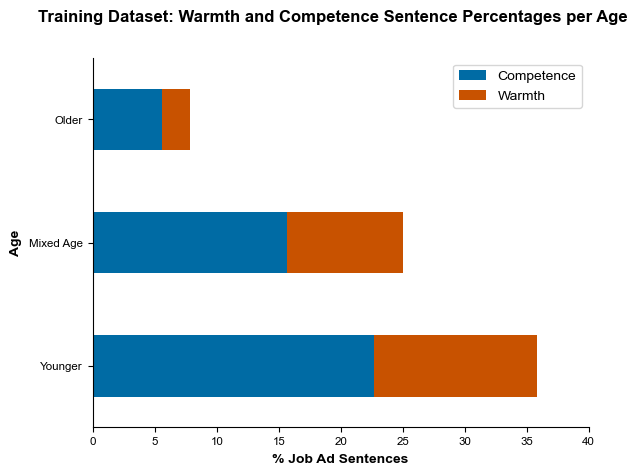

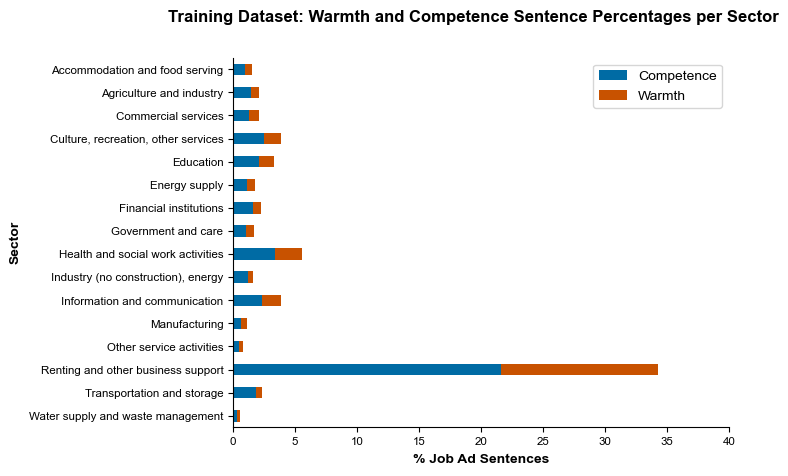

In [86]:
# Make stacked barplots
ivs_list = ['Gender', 'Age', 'Sector']

for iv in ivs_list:
    make_barplot(df_manual, iv=iv, dvs_list=['Warmth', 'Competence'])


In [87]:
def make_lineplot(df, iv, dv):

    df = categorize_df_gender_age(df)

    title = f'Means of {dv}-related frames in job ads from {iv} segregated sectors'
    data = df.groupby(iv)[dv].agg('mean')

    line_plot = sns.lineplot(
        data=data.astype(float), marker='o', legend='full'
    )
    line_plot.set(
        title=title,
        xlabel=f'{iv}-dominated Sector',
        ylabel=f'{dv} Mean',
    )
    fig = line_plot.get_figure()

    for save_format in ['eps', 'png']:
        fig.savefig(
            f'{plot_save_path}Line Plot - Manually Annotated {iv} x {dv} Sentences.{save_format}',
            format=save_format, dpi=3000, bbox_inches='tight'
        )
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()


  0%|          | 0/4 [00:00<?, ?it/s]

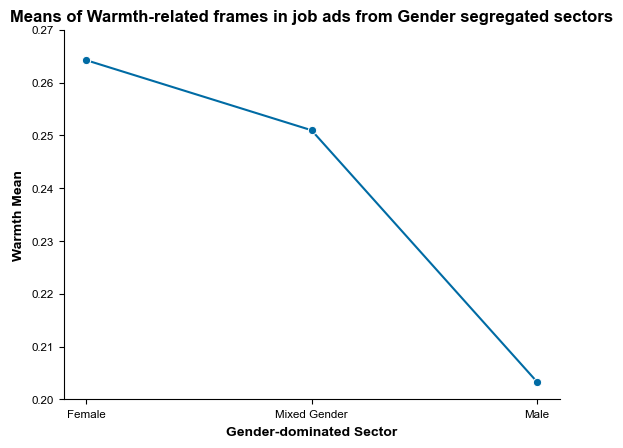

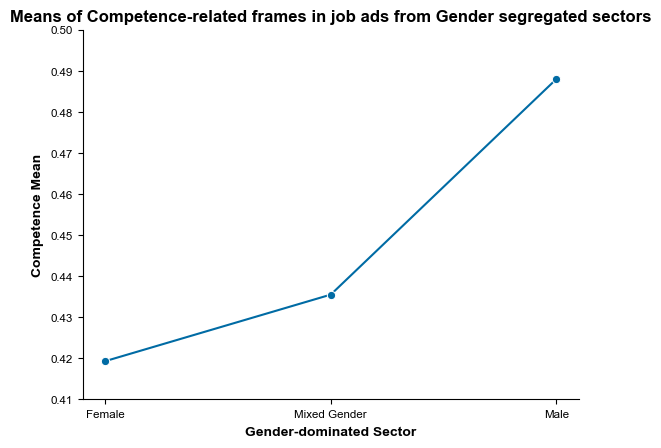

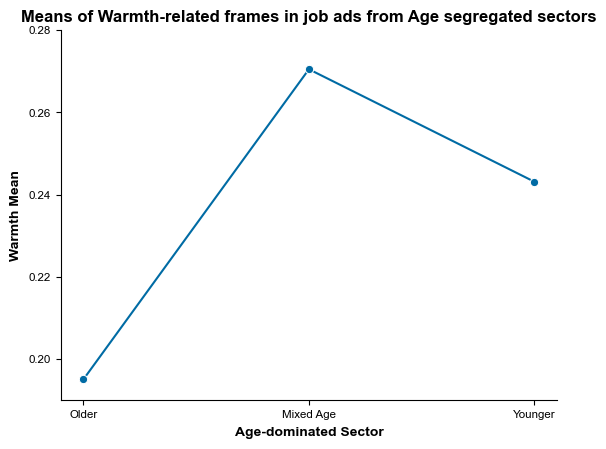

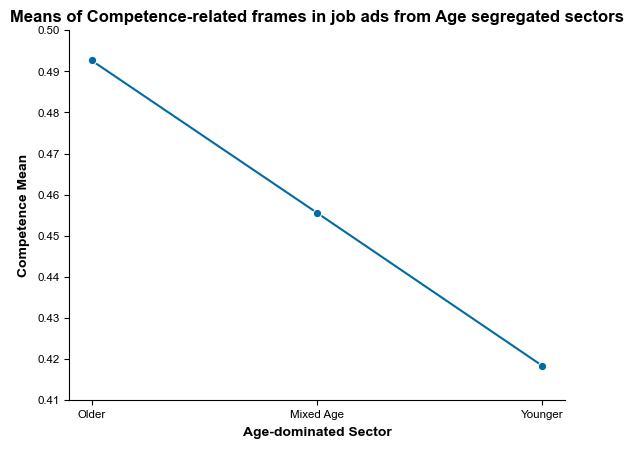

In [88]:
# Make line plots
for iv, dv in tqdm_product(['Gender', 'Age'], ['Warmth', 'Competence']):
    make_lineplot(df_manual, iv=iv, dv=dv)


In [ ]:
fig, ax = plt.subplots()

# ATTN: This script should be run AFTER all visualizations are completed.


### START HERE IF SOURCING FROM df_manual_FOR_TRAINNING
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


# Make descriptive tables


In [14]:
import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

sys.path.append(code_dir)
# %load_ext autoreload
# %autoreload 2


In [15]:
from setup_module.imports import *  # type:ignore # isort:skip # fmt:skip # noqa # nopep8


In [16]:
# Function to order categories
def categorize_df_gender_age(df, gender_order=None, age_order=None, ivs=None):
    if gender_order is None:
        gender_order = ['Female', 'Mixed Gender', 'Male']
    if age_order is None:
        age_order = ['Older', 'Mixed Age', 'Younger']
    if ivs is None:
        ivs = ['Gender', 'Age']

    # Arrange Categories
    for iv in ivs:
        if iv == 'Gender':
            order = gender_order
        elif iv == 'Age':
            order = age_order
        try:
            df[iv] = df[iv].astype('category').cat.reorder_categories(order, ordered=True)

            df[iv] = pd.Categorical(
                df[iv], categories=order, ordered=True
            )
            df[f'{iv}_Num'] = pd.to_numeric(df[iv].cat.codes).astype('int64')
        except ValueError as e:
            print(e)

    return df


In [17]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_for_trainning.pkl').reset_index(drop=True)


### Gender and Age tables

In [44]:
df = df_manual.copy()
gender_order = ['Female', 'Male', 'Mixed Gender']
age_order = ['Older', 'Younger', 'Mixed Age']

ivs_dict = {'Gender': gender_order, 'Age': age_order}

df_desc_gender_dict = defaultdict(list)
df_desc_age_dict = defaultdict(list)

variables = ['Gender', 'Age']
levels = ['Job Advertisement', 'Sentence']
data_types = ['Manually Annotated', 'Collected']

for v, level, data_type in tqdm_product(
    variables, levels, data_types
):
    df = categorize_df_gender_age(df)

    if level.title() == 'Job Advertisement':
        level_df = df.groupby(['Job ID']).first()
    elif level.title() == 'Sentence':
        level_df = df

  0%|          | 0/8 [00:00<?, ?it/s]

In [18]:
# Function to make descriptives tables
def genage_make_descriptives_table(df, v, level, gender_order=None, age_order=None):

    if gender_order is None:
        gender_order = ['Female', 'Male', 'Mixed Gender']
    if age_order is None:
        age_order = ['Older', 'Younger', 'Mixed Age']
    
    ivs_dict = {'Gender': gender_order, 'Age': age_order}

    df = categorize_df_gender_age(df)

    if level.title() == 'Job Advertisement':
        level_df = df.groupby(['Job ID']).first()
    elif level.title() == 'Sentence':
        level_df = df
    else:
        raise AssertionError(f'Specified level {level} not in data.')

    if v in list(ivs_dict.keys()):
        cat_dict = ivs_dict
        index = [
            f'{v_cat}-dominated'
            if 'Mixed' not in v_cat
            else
            f'{"-".join(v_cat.split())}'
            for v_cat in cat_dict[v]
        ]
        caption = [
            f'{v}_{v_cat.split()[0]}'
            for v_cat in cat_dict[v]
        ]

    desc_dict = {
        'Sectors': index,
        'n': [
            level_df[v].value_counts()[v_cat]
            for v_cat in cat_dict[v]
        ],
        '%': [
            level_df[v].value_counts(normalize=True).mul(100).round(2).astype(float)[v_cat]
            for v_cat in cat_dict[v]
        ],
        'M': [
            level_df[caption].mean().round(2).astype(float)[i]
            for i in range(len(cat_dict[v]))
        ],
        'S.D.': [
            level_df[caption].std().round(2).astype(float)[i]
            for i in range(len(cat_dict[v]))
        ]
    }

    # Make DF from dict
    df_desc = pd.DataFrame(desc_dict)
    df_desc = df_desc.set_index('Sectors')

    return df_desc


In [19]:
df_desc_gender_dict = defaultdict(list)
df_desc_age_dict = defaultdict(list)

variables = ['Gender', 'Age']
levels = ['Job Advertisement', 'Sentence']
data_types = ['Manually Annotated', 'Collected']

for v, level, data_type in tqdm_product(
    variables, levels, data_types
):
    cols = [
        (f'{data_type.title()} Job Advertisements', v, level.title(), 'n'),
        (f'{data_type.title()} Job Advertisements', v, level.title(), '%'),
        (f'{data_type.title()} Job Advertisements', v, level.title(), 'M'),
        (f'{data_type.title()} Job Advertisements', v, level.title(), 'S.D.'),
    ]

    df_desc_genage = genage_make_descriptives_table(df=df_manual, v=v, level=level)

    df_desc_genage.columns = pd.MultiIndex.from_tuples(cols)

    if v == 'Gender':
        df_desc_gender_dict[data_type].append(df_desc_genage)
    elif v == 'Age':
        df_desc_age_dict[data_type].append(df_desc_genage)


  0%|          | 0/8 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_77376/3881242042.py:18 in <module>    │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_77376/3881242042.py'                 │
│                                                                                                  │
│ /var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_77376/1713325416.py:44 in             │
│ genage_make_descriptives_table                                                                   │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_77376/1713325416.py'                 │
│                                                                                                  │
│ /var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_77376/1713325416.py:45 in <listcomp>  │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_77376/1713325416.py'                 │
│                                                                                                  │
│ /opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/pandas/core │
│ /frame.py:3813 in __getitem__                                                                    │
│                                                                                                  │
│    3810 │   │   else:                                                                            │
│    3811 │   │   │   if is_iterator(key):                                                         │
│    3812 │   │   │   │   key = list(key)                                                          │
│ ❱  3813 │   │   │   indexer = self.columns._get_indexer_strict(key, "columns")[1]                │
│    3814 │   │                                                                                    │
│    3815 │   │   # take() does not accept boolean indexers                                        │
│    3816 │   │   if getattr(indexer, "dtype", None) == bool:                                      │
│                                                                                                  │
│ /opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/pandas/core │
│ /indexes/base.py:6070 in _get_indexer_strict                                                     │
│                                                                                                  │
│   6067 │   │   else:                                                                             │
│   6068 │   │   │   keyarr, indexer, new_indexer = self._reindex_non_unique(keyarr)               │
│   6069 │   │                                                                                     │
│ ❱ 6070 │   │   self._raise_if_missing(keyarr, indexer, axis_name)                                │
│   6071 │   │                                                                                     │
│   6072 │   │   keyarr = self.take(indexer)                                                       │
│   6073 │   │   if isinstance(key, Index):                                                        │
│                                                                                                  │
│ /opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib

In [20]:
df_desc_genage_dict = defaultdict(list)

for df, data_type in tqdm_product(
    [df_desc_gender_dict, df_desc_age_dict],
    data_types,
):
    category = df[data_type][0].columns.get_level_values(level=1)[0]
    if df[data_type][0].columns.get_level_values(level=2).str.contains('Job Advertisement').all():
        df_desc_genage_dict[category].append(
            pd.concat(
                [
                    df[data_type][0], df[data_type][1]
                ],
                axis='columns'
            )
        )
    else:
        df_desc_genage_dict[category].append(
            pd.concat(
                [
                    df[data_type][1], df[data_type][0]
                ],
                axis='columns'
            )
        )


  0%|          | 0/4 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_77376/1810240343.py:7 in <module>     │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_77376/1810240343.py'                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: list index out of range

In [21]:
for cat, df in df_desc_genage_dict.items():
    df = pd.concat([df[0], df[1]], axis='columns')

    if cat == 'Gender':
        df_desc_gender = df
    elif cat == 'Age':
        df_desc_age = df


In [22]:
# Save Tables
# Gender
df_desc_gender.to_csv(f'{table_save_path}Gender - Job Advertisement Descriptives.csv', index=True)
df_desc_gender.to_pickle(f'{table_save_path}Gender - Job Advertisement Descriptives.pkl')
with pd.option_context('max_colwidth', 10000000000):
    df_desc_gender.to_latex(f'{table_save_path}Gender - Job Advertisement Descriptives.tex', index=True, longtable=True, escape=True, multicolumn=True, multicolumn_format='c', position='H', caption='Number and proportion of job advertisements sample, and resulting sentences for gender and age homogeneous and heterogeneous sectors', label='Descriptives')
df_desc_gender.to_markdown(f'{table_save_path}Gender - Job Advertisement Descriptives.md', index=True)
# save_sector_excel(df_sectors_all, data_save_dir)

# Age
df_desc_age.to_csv(f'{table_save_path}Age - Job Advertisement Descriptives.csv', index=True)
df_desc_age.to_pickle(f'{table_save_path}Age - Job Advertisement Descriptives.pkl')
with pd.option_context('max_colwidth', 10000000000):
    df_desc_age.to_latex(f'{table_save_path}Age - Job Advertisement Descriptives.tex', index=True, longtable=True, escape=True, multicolumn=True, multicolumn_format='c', position='H', caption='Number and proportion of job advertisements sample, and resulting sentences for gender and age homogeneous and heterogeneous sectors', label='Descriptives')
df_desc_age.to_markdown(f'{table_save_path}Age - Job Advertisement Descriptives.md', index=True)
# save_sector_excel(df_sectors_all, data_save_dir)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_77376/935172968.py:3 in <module>      │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_77376/935172968.py'                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'df_desc_gender' is not defined

### Warmth and Competence tables


In [23]:
variables = ['Warmth', 'Competence']

cols = [
    ('Manually Annotated Job Advertisements', 'n'),
    ('Manually Annotated Job Advertisements', '%'),
    ('Manually Annotated Job Advertisements', 'M'),
    ('Manually Annotated Job Advertisements', 'S.D.'),
]

binary_order = [0, 1]
cat_dict = {'Warmth': binary_order, 'Competence': binary_order}

desc_warmcomp_dict = {
    'Frames': list(cat_dict.keys()),
    'n': [
        df_manual[v].value_counts()[1]
        for v in variables
    ],
    '%': [
        df_manual[v].value_counts(normalize=True).mul(100).round(2).astype(float)[1]
        for v in variables
    ],
    'M': list(
        df_manual[variables].mean().round(2).astype(float)
    ),
    'S.D.': list(
        df_manual[variables].std().round(2).astype(float)
    )
}
    
# Make df_manual from dict
df_desc_warmcomp = pd.DataFrame(desc_warmcomp_dict)
df_desc_warmcomp = df_desc_warmcomp.set_index('Frames')
df_desc_warmcomp.columns = pd.MultiIndex.from_tuples(cols)


In [24]:
# Save Tables
df_desc_warmcomp.to_csv(f'{table_save_path}Warmth and Competence - Job Advertisement Descriptives.csv', index=True)
df_desc_warmcomp.to_pickle(f'{table_save_path}Warmth and Competence - Job Advertisement Descriptives.pkl')
with pd.option_context('max_colwidth', 10000000000):
    df_desc_warmcomp.to_latex(f'{table_save_path}Warmth and Competence - Job Advertisement Descriptives.tex', index=True, longtable=True, escape=True, multicolumn=True, multicolumn_format='c', position='H', caption='Number and proportion of job advertisements sample, and resulting sentences for gender and age homogeneous and heterogeneous sectors', label='Descriptives')
df_desc_warmcomp.to_markdown(f'{table_save_path}Warmth and Competence - Job Advertisement Descriptives.md', index=True)
# save_sector_excel(df_sectors_all, data_save_dir)


/var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_77376/772838686.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_desc_warmcomp.to_latex(f'{table_save_path}Warmth and Competence - Job Advertisement Descriptives.tex', index=True, longtable=True, escape=True, multicolumn=True, multicolumn_format='c', position='H', caption='Number and proportion of job advertisements sample, and resulting sentences for gender and age homogeneous and heterogeneous sectors', label='Descriptives')


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/pandas/comp │
│ at/_optional.py:141 in import_optional_dependency                                                │
│                                                                                                  │
│   138 │   │   f"Use pip or conda to install {install_name}."                                     │
│   139 │   )                                                                                      │
│   140 │   try:                                                                                   │
│ ❱ 141 │   │   module = importlib.import_module(name)                                             │
│   142 │   except ImportError:                                                                    │
│   143 │   │   if errors == "raise":                                                              │
│   144 │   │   │   raise ImportError(msg)                                                         │
│                                                                                                  │
│ /opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/importlib/__init__.py:126 │
│ in import_module                                                                                 │
│                                                                                                  │
│   123 │   │   │   if character != '.':                                                           │
│   124 │   │   │   │   break                                                                      │
│   125 │   │   │   level += 1                                                                     │
│ ❱ 126 │   return _bootstrap._gcd_import(name[level:], package, level)                            │
│   127                                                                                            │
│   128                                                                                            │
│   129 _RELOADING = {}                                                                            │
│ <frozen importlib._bootstrap>:1050 in _gcd_import                                                │
│ <frozen importlib._bootstrap>:1027 in _find_and_load                                             │
│ <frozen importlib._bootstrap>:1004 in _find_and_load_unlocked                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ModuleNotFoundError: No module named 'tabulate'

During handling of the above exception, another exception occurred:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_77376/772838686.py:6 in <module>      │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_77376/772838686.py'                  │
│                                                                                                  │
│ /opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/pandas/core │
│ /frame.py:2842 in to_markdown                                                                    │
│                                                                                                  │
│    2839 │   │   kwargs.setdefault("headers", "keys")                                             │
│    2840 │   │   kwargs.setdefault("tablefmt", "pipe")                                            │
│    2841 │   │   kwargs.setdefault("showindex", index)                                            │
│ ❱  2842 │   │   tabulate = import_optional